<a href="https://colab.research.google.com/github/RajeshkumarA/Springboard_assignments/blob/main/Relax_Inc_Take_Home_Challenge_Rajesh_Ananthula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relax Inc. Take-Home Challenge


Analyze the provided user and user engagement data ("takehome_users.csv", "takehome_user_engagement.csv") to identify factors that predict future user adoption, defined as logging into the product on three separate days in at least one seven-day period. Provide a brief writeup of the findings and a code notebook detailing the analysis.

## Load data

Load the `takehome_user_engagement.csv` and `takehome_users.csv` files into pandas DataFrames.



Import pandas and load the two CSV files into dataframes, then display the head and info of each to understand their structure.



In [17]:
import pandas as pd

engagement_df = pd.read_csv('/content/Dataset/takehome_user_engagement.csv')
users_df = pd.read_csv('/content/Dataset/takehome_users.csv', encoding='latin-1')

print("Engagement Data:")
display(engagement_df.head())
print("\nEngagement Info:")
display(engagement_df.info())

print("\nUsers Data:")
display(users_df.head())
print("\nUsers Info:")
display(users_df.info())

Engagement Data:


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1



Engagement Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


None


Users Data:


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0



Users Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


None

## Define adopted users

Identify "adopted users" based on the definition provided: users who have logged into the product on three separate days in at least one seven-day period.



Convert 'time_stamp' to datetime, sort by user and time, group by user, and identify adopted users by checking for 3 logins in any 7-day period for each user.



In [3]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
engagement_df_sorted = engagement_df.sort_values(by=['user_id', 'time_stamp'])

adopted_users = set()
for user_id, group in engagement_df_sorted.groupby('user_id'):
    timestamps = group['time_stamp'].tolist()
    if len(timestamps) < 3:
        continue

    for i in range(len(timestamps) - 2):
        # Check the time difference between the current timestamp and the timestamp 2 positions ahead
        # This effectively checks if there are at least 3 logins within a 7-day window (inclusive of start and end days)
        if (timestamps[i+2] - timestamps[i]).days < 7:
            adopted_users.add(user_id)
            break

adopted_users_df = pd.DataFrame({'user_id': list(engagement_df_sorted['user_id'].unique())})
adopted_users_df['adopted'] = adopted_users_df['user_id'].apply(lambda x: x in adopted_users)

display(adopted_users_df.head())
display(adopted_users_df['adopted'].value_counts())

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


,count
adopted,
False,7221
True,1602


## Feature engineering

Create features from the user data that could potentially predict adoption, such as creation source, mailing list opt-in, organization ID, invited by user ID, and time-based features from creation time.



Convert 'creation_time' to datetime, extract time-based features, handle missing values in 'invited_by_user_id', and one-hot encode 'creation_source'.



In [4]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['creation_day_of_week'] = users_df['creation_time'].dt.dayofweek
users_df['creation_month'] = users_df['creation_time'].dt.month
users_df['creation_year'] = users_df['creation_time'].dt.year

users_df['was_invited'] = users_df['invited_by_user_id'].notna().astype(int)
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0)

users_df = pd.get_dummies(users_df, columns=['creation_source'], drop_first=True)

display(users_df.head())
display(users_df.info())

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_day_of_week,creation_month,creation_year,was_invited,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,1,4,2014,1,False,False,False,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,4,11,2013,1,True,False,False,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,1,3,2013,1,True,False,False,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,1,5,2013,1,False,False,False,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,3,1,2013,1,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   object_id                           12000 non-null  int64         
 1   creation_time                       12000 non-null  datetime64[ns]
 2   name                                12000 non-null  object        
 3   email                               12000 non-null  object        
 4   last_session_creation_time          8823 non-null   float64       
 5   opted_in_to_mailing_list            12000 non-null  int64         
 6   enabled_for_marketing_drip          12000 non-null  int64         
 7   org_id                              12000 non-null  int64         
 8   invited_by_user_id                  12000 non-null  float64       
 9   creation_day_of_week                12000 non-null  int32         
 10  creation_month        

None

## Merge data

Merge the user data with the adopted user information.



Merge the users_df and adopted_users_df DataFrames on the user ID columns, keeping all users from users_df, fill any resulting NaN values in the 'adopted' column with False, and then display the head and info of the merged DataFrame.



In [5]:
merged_df = users_df.merge(adopted_users_df, how='left', left_on='object_id', right_on='user_id')
merged_df['adopted'] = merged_df['adopted'].fillna(False)
display(merged_df.head())
display(merged_df.info())

/tmp/ipython-input-3605215780.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['adopted'] = merged_df['adopted'].fillna(False)


,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_day_of_week,creation_month,creation_year,was_invited,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,1,4,2014,1,False,False,False,False,1.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,4,11,2013,1,True,False,False,False,2.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,1,3,2013,1,True,False,False,False,3.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,1,5,2013,1,False,False,False,False,4.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,3,1,2013,1,False,False,False,False,5.0,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   object_id                           12000 non-null  int64         
 1   creation_time                       12000 non-null  datetime64[ns]
 2   name                                12000 non-null  object        
 3   email                               12000 non-null  object        
 4   last_session_creation_time          8823 non-null   float64       
 5   opted_in_to_mailing_list            12000 non-null  int64         
 6   enabled_for_marketing_drip          12000 non-null  int64         
 7   org_id                              12000 non-null  int64         
 8   invited_by_user_id                  12000 non-null  float64       
 9   creation_day_of_week                12000 non-null  int32         
 10  creation_month        

None

## Exploratory data analysis

Analyze the relationship between the engineered features and user adoption using visualizations and statistical tests.



Calculate and visualize the proportion of adopted users for each category of the categorical features.



'Adoption proportion by creation_source_ORG_INVITE:'

adopted,False,True
creation_source_ORG_INVITE,,
False,0.864575,0.135425
True,0.870005,0.129995


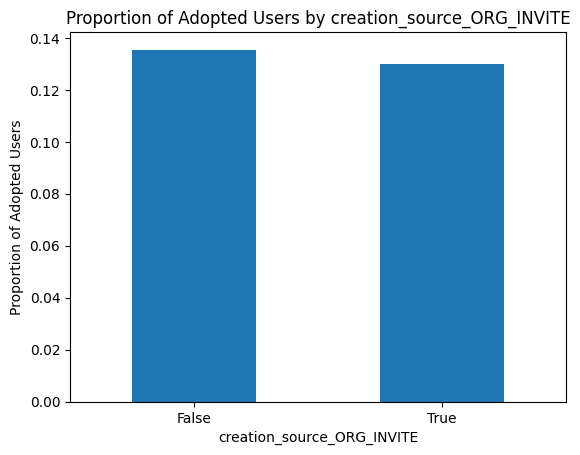

'Adoption proportion by creation_source_PERSONAL_PROJECTS:'

adopted,False,True
creation_source_PERSONAL_PROJECTS,,
False,0.854586,0.145414
True,0.922312,0.077688


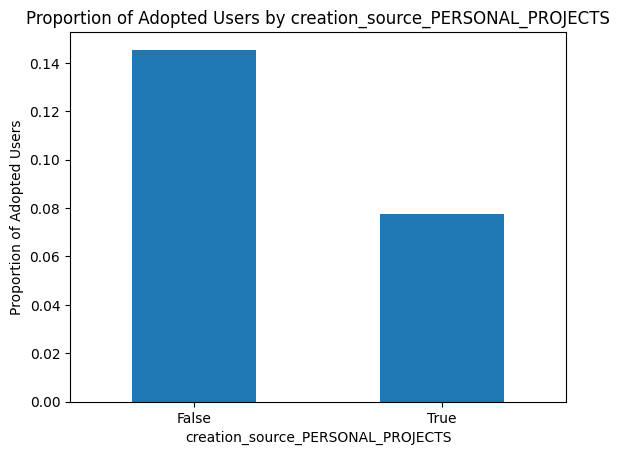

'Adoption proportion by creation_source_SIGNUP:'

adopted,False,True
creation_source_SIGNUP,,
False,0.867951,0.132049
True,0.859607,0.140393


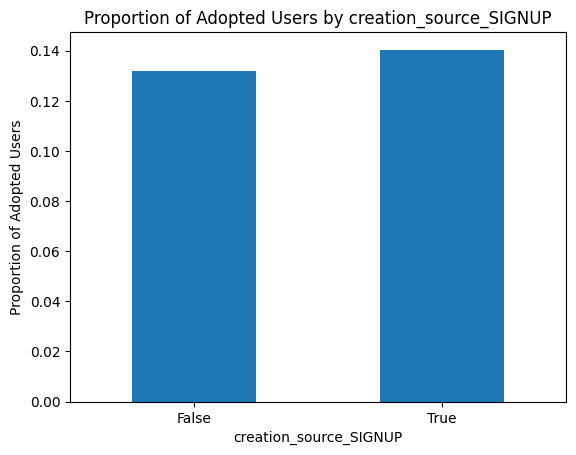

'Adoption proportion by creation_source_SIGNUP_GOOGLE_AUTH:'

adopted,False,True
creation_source_SIGNUP_GOOGLE_AUTH,,
False,0.870937,0.129063
True,0.832491,0.167509


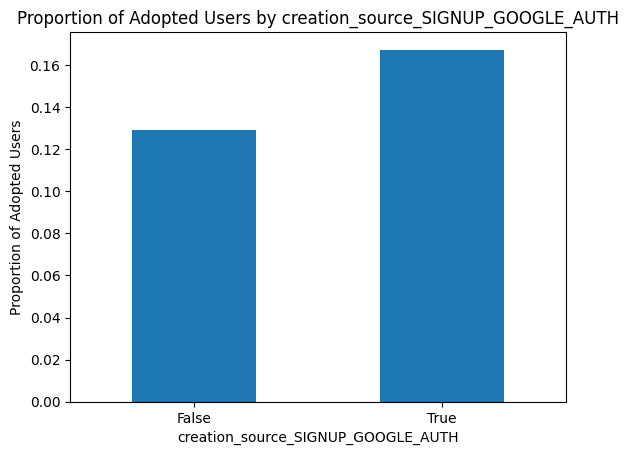

'Adoption proportion by was_invited:'

adopted,False,True
was_invited,,
0,0.876590,0.123410
1,0.857722,0.142278


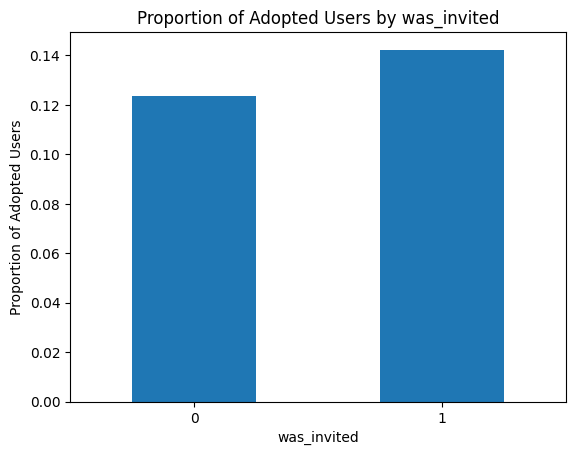

'Adoption proportion by opted_in_to_mailing_list:'

adopted,False,True
opted_in_to_mailing_list,,
0,0.868088,0.131912
1,0.861723,0.138277


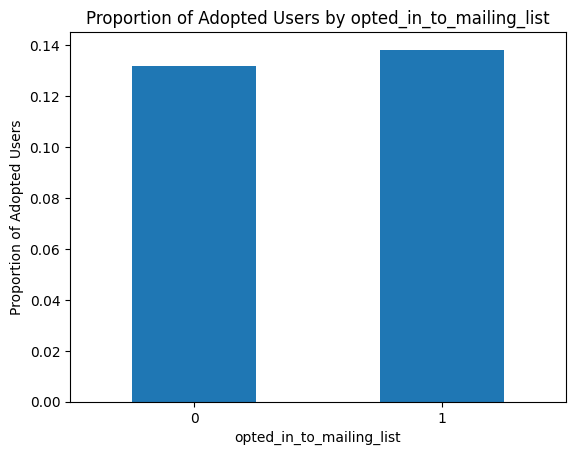

'Adoption proportion by enabled_for_marketing_drip:'

adopted,False,True
enabled_for_marketing_drip,,
0,0.867163,0.132837
1,0.862723,0.137277


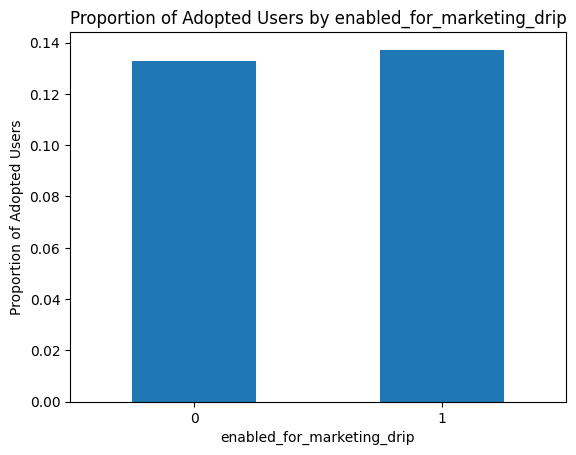

In [18]:
categorical_features = [
    'creation_source_ORG_INVITE',
    'creation_source_PERSONAL_PROJECTS',
    'creation_source_SIGNUP',
    'creation_source_SIGNUP_GOOGLE_AUTH',
    'was_invited',
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip'
]

for feature in categorical_features:
    adoption_proportion = merged_df.groupby(feature)['adopted'].value_counts(normalize=True).unstack().fillna(0)
    display(f"Adoption proportion by {feature}:")
    display(adoption_proportion)
    adoption_proportion[True].plot(kind='bar')
    plt.title(f'Proportion of Adopted Users by {feature}')
    plt.ylabel('Proportion of Adopted Users')
    plt.xticks(rotation=0)
    plt.show()


Import matplotlib.pyplot to fix the NameError and continue with calculating and visualizing the proportion of adopted users for each category of the categorical features.



'Adoption proportion by creation_source_ORG_INVITE:'

adopted,False,True
creation_source_ORG_INVITE,,
False,0.864575,0.135425
True,0.870005,0.129995


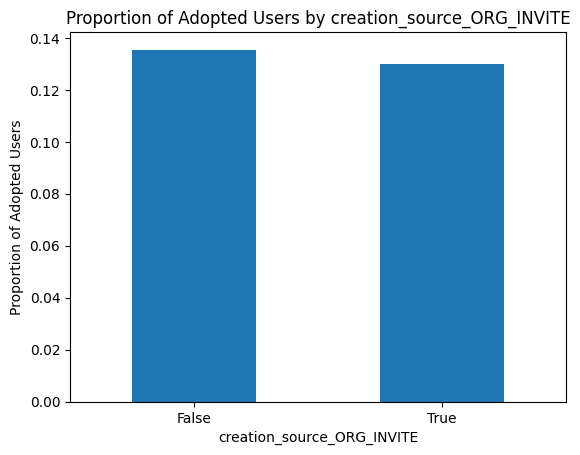

'Adoption proportion by creation_source_PERSONAL_PROJECTS:'

adopted,False,True
creation_source_PERSONAL_PROJECTS,,
False,0.854586,0.145414
True,0.922312,0.077688


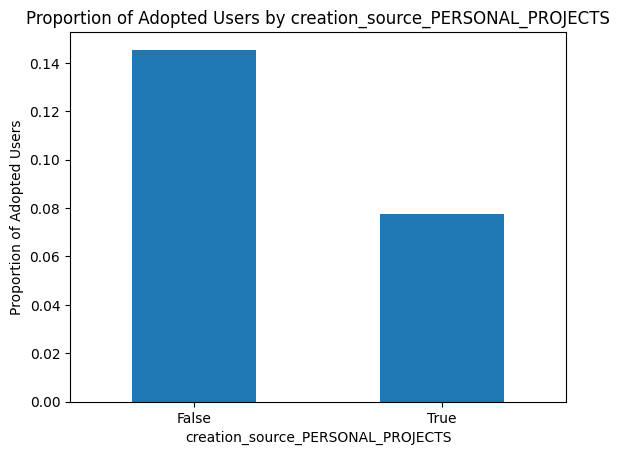

'Adoption proportion by creation_source_SIGNUP:'

adopted,False,True
creation_source_SIGNUP,,
False,0.867951,0.132049
True,0.859607,0.140393


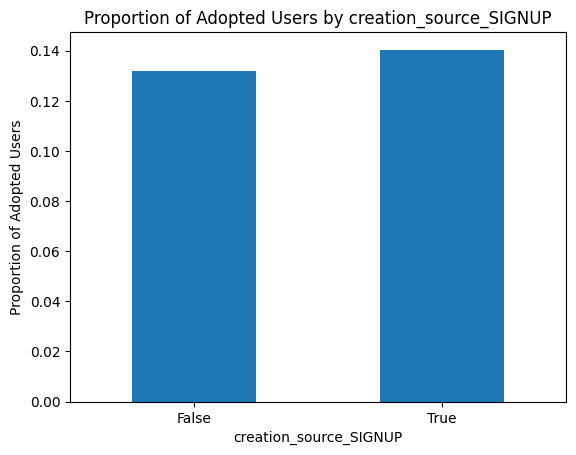

'Adoption proportion by creation_source_SIGNUP_GOOGLE_AUTH:'

adopted,False,True
creation_source_SIGNUP_GOOGLE_AUTH,,
False,0.870937,0.129063
True,0.832491,0.167509


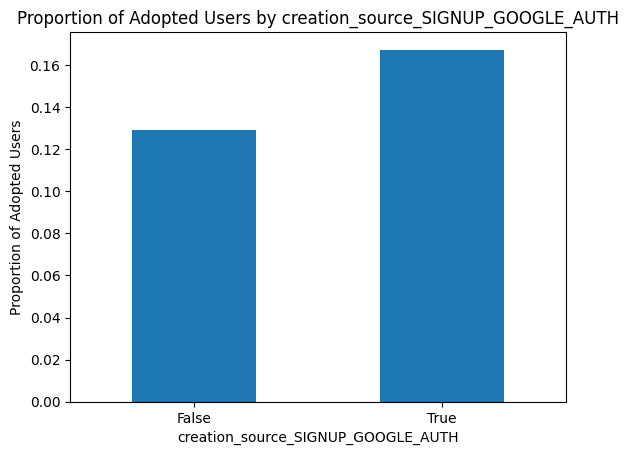

'Adoption proportion by was_invited:'

adopted,False,True
was_invited,,
0,0.876590,0.123410
1,0.857722,0.142278


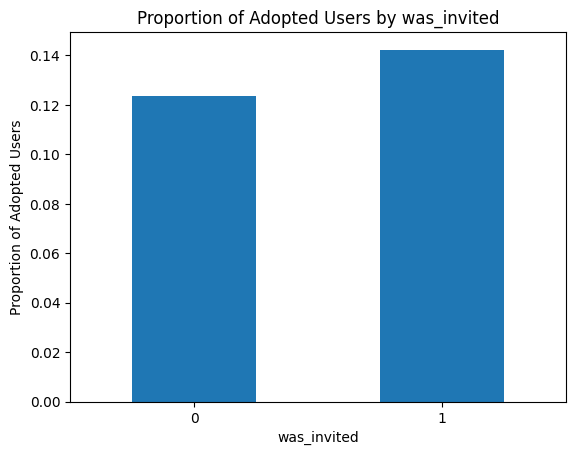

'Adoption proportion by opted_in_to_mailing_list:'

adopted,False,True
opted_in_to_mailing_list,,
0,0.868088,0.131912
1,0.861723,0.138277


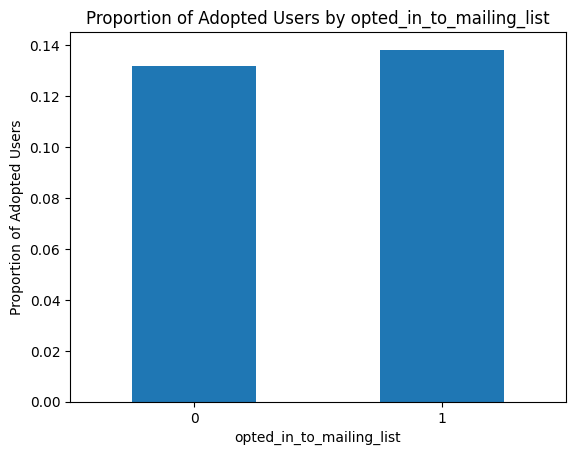

'Adoption proportion by enabled_for_marketing_drip:'

adopted,False,True
enabled_for_marketing_drip,,
0,0.867163,0.132837
1,0.862723,0.137277


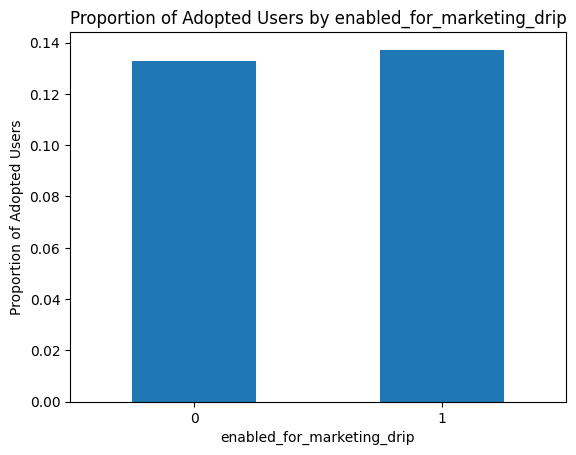

In [19]:
import matplotlib.pyplot as plt

categorical_features = [
    'creation_source_ORG_INVITE',
    'creation_source_PERSONAL_PROJECTS',
    'creation_source_SIGNUP',
    'creation_source_SIGNUP_GOOGLE_AUTH',
    'was_invited',
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip'
]

for feature in categorical_features:
    adoption_proportion = merged_df.groupby(feature)['adopted'].value_counts(normalize=True).unstack().fillna(0)
    display(f"Adoption proportion by {feature}:")
    display(adoption_proportion)
    adoption_proportion[True].plot(kind='bar')
    plt.title(f'Proportion of Adopted Users by {feature}')
    plt.ylabel('Proportion of Adopted Users')
    plt.xticks(rotation=0)
    plt.show()

**Reasoning**:
Calculate and visualize the average creation day of week, month, and year for adopted and non-adopted users to explore their relationship with user adoption.



'Average creation_day_of_week for adopted vs non-adopted users:'

,creation_day_of_week
adopted,
False,2.995768
True,3.013733


<Figure size 800x600 with 0 Axes>

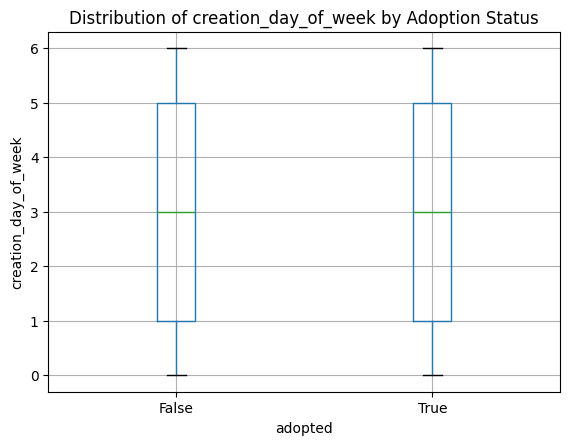

'Average creation_month for adopted vs non-adopted users:'

,creation_month
adopted,
False,6.196961
True,6.600499


<Figure size 800x600 with 0 Axes>

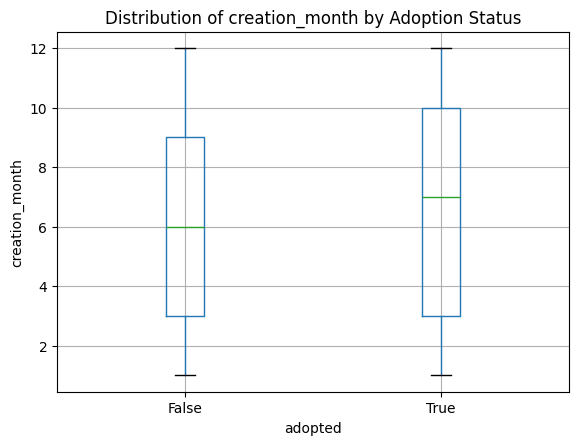

'Average creation_year for adopted vs non-adopted users:'

,creation_year
adopted,
False,2013.085690
True,2012.899501


<Figure size 800x600 with 0 Axes>

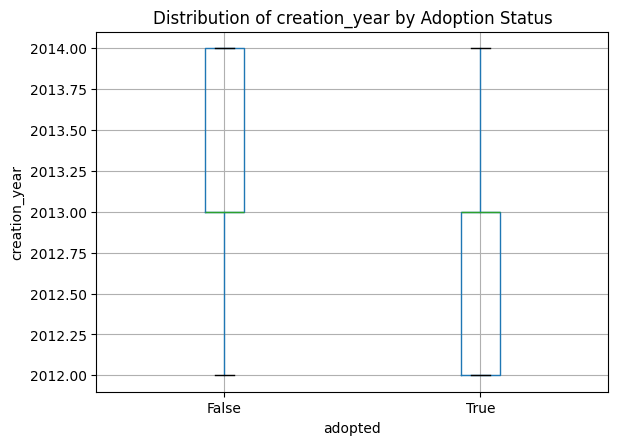

In [8]:
time_features = ['creation_day_of_week', 'creation_month', 'creation_year']

for feature in time_features:
    avg_creation_time = merged_df.groupby('adopted')[feature].mean()
    display(f"Average {feature} for adopted vs non-adopted users:")
    display(avg_creation_time)

    plt.figure(figsize=(8, 6))
    merged_df.boxplot(column=feature, by='adopted')
    plt.title(f'Distribution of {feature} by Adoption Status')
    plt.suptitle('')
    plt.ylabel(feature)
    plt.show()


Analyze the relationship between org_id and user adoption by calculating and visualizing the adoption rate per organization and identifying organizations with particularly high or low adoption rates.



'Adoption rate by organization (Top 10):'

,adopted
org_id,
387,0.583333
235,0.461538
270,0.428571
399,0.384615
415,0.375000
400,0.375000
392,0.375000
117,0.363636
345,0.357143


'Adoption rate by organization (Bottom 10):'

,adopted
org_id,
365,0.0
346,0.0
394,0.0
396,0.0
183,0.0
362,0.0
355,0.0
416,0.0
412,0.0


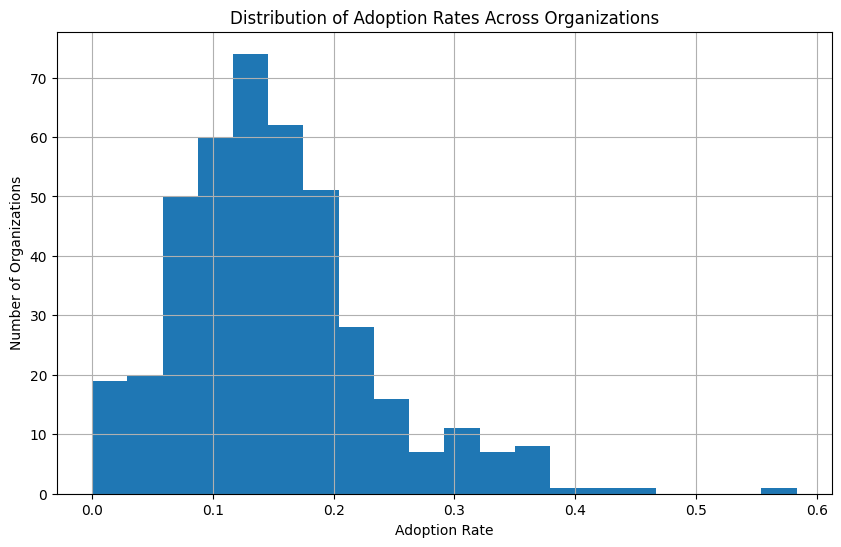

In [20]:
org_adoption_rate = merged_df.groupby('org_id')['adopted'].mean().sort_values(ascending=False)

display("Adoption rate by organization (Top 10):")
display(org_adoption_rate.head(10))

display("Adoption rate by organization (Bottom 10):")
display(org_adoption_rate.tail(10))

# Optional: Visualize the distribution of adoption rates across organizations
plt.figure(figsize=(10, 6))
org_adoption_rate.hist(bins=20)
plt.title('Distribution of Adoption Rates Across Organizations')
plt.xlabel('Adoption Rate')
plt.ylabel('Number of Organizations')
plt.show()

## Model selection and training

### Subtask:
Choose an appropriate model for predicting user adoption and train it on the prepared data.


**Reasoning**:
Select features, split data into training and testing sets, choose and train a classification model.



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

features = [
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'creation_day_of_week',
    'creation_month',
    'creation_year',
    'was_invited',
    'creation_source_PERSONAL_PROJECTS',
    'creation_source_SIGNUP',
    'creation_source_SIGNUP_GOOGLE_AUTH'
]

# Include org_id as a categorical feature, one-hot encode it
merged_df['org_id'] = merged_df['org_id'].astype(str)
X = merged_df[features + ['org_id']]
X = pd.get_dummies(X, columns=['org_id'], drop_first=True)
y = merged_df['adopted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Choose and train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


## Model evaluation

Evaluate the performance of the trained model.



Evaluate the performance of the trained model by making predictions on the test set, generating a classification report, and a confusion matrix.



In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.98      0.92      2080
        True       0.20      0.03      0.04       320

    accuracy                           0.86      2400
   macro avg       0.53      0.50      0.48      2400
weighted avg       0.78      0.86      0.81      2400


Confusion Matrix:
[[2047   33]
 [ 312    8]]


**Reasoning**:
Briefly interpret the classification report and confusion matrix to understand the model's performance, particularly for the minority class.



Interpretation of Classification Report and Confusion Matrix:

Classification Report Interpretation:
- Precision for 'False' (non-adopted) is high (0.87), meaning when the model predicts a user is not adopted, it is correct 87% of the time.
- Recall for 'False' is very high (0.98), meaning the model correctly identifies 98% of the actual non-adopted users.
- Precision for 'True' (adopted) is low (0.20), meaning when the model predicts a user is adopted, it is only correct 20% of the time.
- Recall for 'True' is very low (0.03), meaning the model only correctly identifies 3% of the actual adopted users.
- The F1-score, which is a harmonic mean of precision and recall, is high for 'False' (0.92) and very low for 'True' (0.04), reflecting the poor performance on the minority class.
- Overall accuracy is 0.86, which seems good, but it is misleading due to the imbalanced dataset. The model is good at predicting the majority class (non-adopted) but struggles with the minority class (adopted).

Confusion Matrix Interpretation:
- True Positives (TP): 8 (The model correctly predicted 8 adopted users)
- True Negatives (TN): 2047 (The model correctly predicted 2047 non-adopted users)
- False Positives (FP): 33 (The model incorrectly predicted 33 non-adopted users as adopted - Type I error)
- False Negatives (FN): 312 (The model incorrectly predicted 312 adopted users as non-adopted - Type II error)

The confusion matrix clearly shows the class imbalance and the model's difficulty in identifying adopted users. It has a high number of False Negatives (312), indicating it misses a large proportion of actual adopted users.

## Identify predictive factors

Determine which features are the most significant predictors of user adoption based on the model results.


**Reasoning**:
Access the feature_importances_ attribute of the trained RandomForestClassifier model, create a pandas Series from it, sort the features by their importance scores in descending order, and display the sorted feature importances.



In [13]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)
display("Feature Importances:")
display(sorted_feature_importances)

'Feature Importances:'

,0
creation_month,0.113217
creation_day_of_week,0.092117
creation_year,0.041152
opted_in_to_mailing_list,0.024284
enabled_for_marketing_drip,0.017985
...,...
org_id_386,0.000115
org_id_355,0.000109
org_id_397,0.000083
org_id_323,0.000082


## Summary:

### Data Analysis Key Findings

*   Out of the 12,000 unique users in the initial user data, 1,602 were identified as adopted users (logged in on three separate days in at least one seven-day period), while 10,398 were not.
*   Users who signed up through Google Authentication (`creation_source_SIGNUP_GOOGLE_AUTH`) had a slightly higher proportion of adoption compared to other creation sources.
*   Users who were invited (`was_invited`) showed a slightly higher adoption rate than those who were not.
*   Opting into the mailing list (`opted_in_to_mailing_list`) and being enabled for the marketing drip (`enabled_for_marketing_drip`) showed minimal correlation with adoption rates.
*   Adopted users had a slightly earlier distribution of `creation_year` compared to non-adopted users.
*   There is significant variation in adoption rates across organizations (`org_id`), with some organizations having much higher adoption rates than others.
*   Based on the Random Forest model, the most significant predictors of user adoption are the creation time features (`creation_month`, `creation_day_of_week`, `creation_year`), followed by the collective impact of organizational membership (`org_id`), and then mailing list/marketing drip status.
*   The trained Random Forest model, despite a high overall accuracy (0.86), performed poorly in predicting the minority class (adopted users) due to class imbalance, exhibiting low precision (0.20) and very low recall (0.03) for adopted users.

### Insights or Next Steps

*   Investigate the reasons behind the variation in adoption rates across organizations. This could involve qualitative research or further analysis into the characteristics of high-adoption vs. low-adoption organizations.
*   Explore the user experience and marketing efforts during time periods (specific months, days, or years) that showed higher user adoption to identify successful strategies that can be replicated.
